In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

In [2]:
def splitDataset(dataset, trainRatio):
    trainSize = int(len(dataset) * trainRatio)
    trainSet = []
    copy = list(dataset.iloc[:,:].values)
    while len(trainSet) < trainSize:
        index = random.randrange(len(copy))
        trainSet.append(copy.pop(index))
    return [np.array(trainSet), np.array(copy)]

def calc_centroids(dataset, labels):
    dataset=pd.DataFrame(dataset)
    centroids=[]
    for label in labels:
        centroids.append((list((dataset[dataset['Target']==label].iloc[:,:-1]).sum()/len(dataset[dataset['Target']==label])),label))
    return(centroids)

def calc_products(dataset,amostra,labels):
    products=[]
    for label in labels:
        cov_mat=dataset[dataset.Target==label].iloc[:,:-1].cov()
        try:
            inv_cov_mat=np.linalg.inv(cov_mat)
        except:
            inv_cov_mat=np.linalg.pinv(cov_mat)        
        centroid = calc_centroids(dataset,[label])
        x=amostra-centroid[0][0]
        product=np.dot(np.dot(x,inv_cov_mat),x.transpose())
        products.append((product, centroid[0][1]))
        
    return(products)        

def att_class(dataset,amostra,labels):
    dataset=pd.DataFrame(dataset)    
    products=calc_products(dataset,amostra,labels)
    products.sort()
    return(products[0][1])

def make_pred(dataset,amostras):
    labels = list(dataset.iloc[:,-1].unique())
    preds=[]
    for amostra in amostras:
        preds.append(att_class(dataset, amostra,labels))
    return(preds)

In [3]:
def prepare_to_remove(dataset):
    """
    Calcula algumas estatísticas para a remoção de outliers do dataset.
    
    Input
    ----------
    dataset: 
    Dataset a ser preparado para remoção de outliers.
    
    Output
    ----------
    cols:
    Lista contendo os nomes das colunas dos datasets.
  
    means:
    Lista contendo as médias das colunas dos datasets.
  
    stds:
    Lista contendo os desios padrões das colunas dos datasets.
  
    """
    cols, means, stds = [],[],[]
    for col in dataset.columns:
        try:
            cols.append(col)
            means.append(dataset[col].mean())
            stds.append(dataset[col].std())
        except TypeError:
            means.append(np.nan)
            stds.append(np.nan)
            print(f'Coluna {col} possui valores em formato não númerico!')
    return(cols, means, stds)

def remove_outliers(dataset):
    """
    Soma todos os elementos de um vetor, exceto o que está na posição n.
    
    
    Input
    ----------
    dataset: 
    Dataset para remoção de outliers.
    
    Output
    ----------
    dataset:
    O dataset da entrada, agora com os outliers removidos
    
    
    Obs.: São consideradas outliers da variável x, observações além do intervalo: mean(x) ± 2*std(x).
    """
    cols, means, stds = prepare_to_remove(dataset)
    k=0
    for col in cols:
        dataset = dataset.loc[(dataset[col] > means[k]-2*stds[k]) & (dataset[col] < means[k]+2*stds[k])]
        k=k+1
    return(dataset)

def formata_matriz(M):
    m = len(M) 
    n = len(M[0])
    s = ''
    for i in range(m):
        for j in range(n):
            s += f'{M[i][j]} '
        s += '\n'
    return s

In [4]:
sc = StandardScaler()
path='https://raw.githubusercontent.com/rhanielmx/RecPad/master/messidor_features.csv'
trainRatio=0.8
n_rounds=100

In [5]:
def before_feature_selection():    
    for _ in range(n_rounds):
        data=pd.read_csv(path)
        data=remove_outliers(data)
        data.iloc[:,:-1]=sc.fit_transform(data.iloc[:,:-1])
        
        train_set, test_set = splitDataset(dataset=data,trainRatio=trainRatio)
        X_test=[test_set[i][:-1] for i in range(test_set.shape[0])]
        y_test=[test_set[i][-1] for i in range(test_set.shape[0])]

        preds=make_pred(data,np.array(X_test))      
        
        cm = confusion_matrix(y_test, preds)
        sr = 100*(cm.diagonal().sum()/cm.sum())
        confusion_matrixes.append(cm)
        accuracys.append(sr)
        
        class0_success=100*cm[0][0]/(cm[0][0]+cm[0][1])
        class1_success=100*cm[1][1]/(cm[1][0]+cm[1][1])
         
        class0_successes.append(class0_success)
        class1_successes.append(class1_success)

        if ((_+1)%(int(n_rounds/10))==0):
            print(f'{(_+1)*(100/n_rounds):05.2f}% concluído!')

In [6]:
accuracys = []
confusion_matrixes = []
class0_successes,class1_successes=[],[]

%time before_feature_selection()

10.00% concluído!
20.00% concluído!
30.00% concluído!
40.00% concluído!
50.00% concluído!
60.00% concluído!
70.00% concluído!
80.00% concluído!
90.00% concluído!
100.00% concluído!
Wall time: 9min 52s


In [7]:
statistics=pd.DataFrame(data={'Estatísticas':[np.mean(accuracys),np.min(accuracys),np.max(accuracys),np.median(accuracys),np.std(accuracys,ddof=1)]},index=['Média','Mín','Máx','Mediana','Desvio P.'])
avg_sucess=pd.DataFrame(data={'Sucesso Médio(%)':[np.mean(class0_successes),np.mean(class1_successes)]},index=['Classe 0', 'Classe 1'])

In [8]:
data=pd.read_csv(path)
data=remove_outliers(data)
feature_importances=[]
cols_names=[]
for i in range(50):
    train_set, test_set = splitDataset(dataset=data,trainRatio=trainRatio)
    X_train,y_train=[train_set[i][:-1] for i in range(train_set.shape[0])],[train_set[i][-1] for i in range(train_set.shape[0])]
    X_test,y_test=[test_set[i][:-1] for i in range(test_set.shape[0])],[test_set[i][-1] for i in range(test_set.shape[0])]

    from sklearn.ensemble import RandomForestClassifier 
    rf = RandomForestClassifier() 
    rf.fit(X_train, y_train) 

    feature_importances.append(rf.feature_importances_)

avg_feature_importances=sum(feature_importances)/len(feature_importances)
avg_feature_importances=pd.DataFrame(avg_feature_importances*100,columns=['Average Importance(%)'],index=list(data.columns[:-1]))

print(avg_feature_importances.sort_values('Average Importance(%)',ascending=False))
cols_to_use=[avg_feature_importances.index[i] for i in range(len(avg_feature_importances.index)) if (avg_feature_importances.iloc[i,0]>=(avg_feature_importances).mean()[0])==True]
cols_to_use.append('Target')

data=pd.read_csv(filepath_or_buffer=path,usecols=cols_to_use)
data=remove_outliers(data)

corr_matrix = data.iloc[:,:-1].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_remove = [column for column in upper.columns if any(upper[column] > 0.95)]
[cols_to_use.remove(col) for col in to_remove];

                            Average Importance(%)
Exudates_Detection_1                     9.235332
MA_Detection_alpha-0.5                   8.423067
Exudates_Detection_2                     7.910521
Macula_OpticDisc_Distance                7.627371
OpticDisc_Diameter                       7.547148
Exudates_Detection_3                     7.272723
Exudates_Detection_4                     6.919972
MA_Detection_alpha-0.6                   6.380381
MA_Detection_alpha-1.0                   5.569834
MA_Detection_alpha-0.7                   5.483971
MA_Detection_alpha-0.9                   5.364224
MA_Detection_alpha-0.8                   5.090567
Exudates_Detection_5                     5.028658
Exudates_Detection_7                     4.570932
Exudates_Detection_6                     3.595873
Exudates_Detection_8                     3.067614
AM/FM-based classification               0.911811
Pre-Screening                            0.000000
Quality_Assessment                       0.000000


In [9]:
sc = StandardScaler()
def after_feature_selection():    
    for _ in range(n_rounds):
        data=pd.read_csv(filepath_or_buffer=path,usecols=cols_to_use)
        data=remove_outliers(data)
        data.iloc[:,:-1]=sc.fit_transform(data.iloc[:,:-1])
        
        train_set, test_set = splitDataset(dataset=data,trainRatio=trainRatio)
        X_test=[test_set[i][:-1] for i in range(test_set.shape[0])]
        y_test=[test_set[i][-1] for i in range(test_set.shape[0])]

        preds=make_pred(data,np.array(X_test))      
        
        cm = confusion_matrix(y_test, preds)
        sr = 100*(cm.diagonal().sum()/cm.sum())
        new_confusion_matrixes.append(cm)
        new_accuracys.append(sr)
        
        class0_success=100*cm[0][0]/(cm[0][0]+cm[0][1])
        class1_success=100*cm[1][1]/(cm[1][0]+cm[1][1])
         
        new_class0_successes.append(class0_success)
        new_class1_successes.append(class1_success)

        if ((_+1)%(int(n_rounds/10))==0):
            print(f'{(_+1)*(100/n_rounds):05.2f}% concluído!')

In [10]:
new_accuracys = []
new_confusion_matrixes = []
new_class0_successes,new_class1_successes=[],[]

%time after_feature_selection()

10.00% concluído!
20.00% concluído!
30.00% concluído!
40.00% concluído!
50.00% concluído!
60.00% concluído!
70.00% concluído!
80.00% concluído!
90.00% concluído!
100.00% concluído!
Wall time: 5min 6s


In [11]:
new_statistics=pd.DataFrame(data={'Estatísticas':[np.mean(new_accuracys),np.min(new_accuracys),np.max(new_accuracys),np.median(new_accuracys),np.std(new_accuracys,ddof=1)]},index=['Média','Mín','Máx','Mediana','Desvio P.'])
new_avg_sucess=pd.DataFrame(data={'Sucesso Médio(%)':[np.mean(new_class0_successes),np.mean(new_class1_successes)]},index=['Classe 0', 'Classe 1'])

In [12]:
pd.concat([avg_sucess,new_avg_sucess],axis=1)

,Sucesso Médio(%),Sucesso Médio(%)
Classe 0,32.591613,56.019784
Classe 1,92.076610,71.918313


In [13]:
pd.concat([statistics,new_statistics],axis=1)

,Estatísticas,Estatísticas
Média,60.557576,63.958115
Mín,51.515152,57.591623
Máx,67.878788,69.633508
Mediana,60.606061,63.350785
Desvio P.,3.502992,2.731894


In [14]:
worst_accuracy=new_accuracys.index(np.min(new_accuracys))
best_accuracy=new_accuracys.index(np.max(new_accuracys))
worst_matrix=new_confusion_matrixes[worst_accuracy]
best_matrix=new_confusion_matrixes[best_accuracy]

In [15]:
print(f'Matriz de confusão para o pior caso:\n{formata_matriz(worst_matrix)}\nMatriz de confusão para o melhor caso:\n{formata_matriz(best_matrix)}')

Matriz de confusão para o pior caso:
38 45 
36 72 

Matriz de confusão para o melhor caso:
60 35 
23 73 



In [16]:
data=pd.read_csv(path)
data=remove_outliers(data)
train_set, test_set = splitDataset(dataset=data,trainRatio=trainRatio)
y_test=[test_set[i][-1] for i in range(test_set.shape[0])]
scores=pd.read_csv('https://raw.githubusercontent.com/rhanielmx/RecPad/master/scores2.csv',names='Scores').iloc[:,0].values

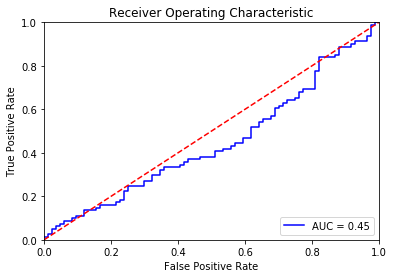

In [17]:
fpr, tpr, threshold = metrics.roc_curve(y_test, scores)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()